# Prep Glider Data

## Imports

In [1]:
# Imports
import scipy.interpolate as interp
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.distance import geodesic
import dbdreader
import pyompa
from scipy.interpolate import interp1d
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.gridspec as gridspec


###################################################################################################################
######################################### Setting for water mass analysis #########################################
###################################################################################################################

#Define a parameter to represent remineralization in terms of phosphate
convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen_concentration": -170, "phosphate": 1.0}],
        always_positive=True)
]

paramweightings = {
    "potential_temperature": 1.0,
    "salinity": 1.0,
    "mass": 1.0,
}

settings = {
    "param_names": ["potential_temperature", "salinity", "mass"],
    "convertedparam_groups": convertedparamgroups,
    "param_weightings": paramweightings,
}


## Some functions

In [37]:
########################################################################################################
def calc_segment_water_mass_transport(ds):
    segment_naw_transport = np.empty(len(ds.time))
    segment_naw_transport[:] = np.nan
    segment_saw_transport = np.empty(len(ds.time))
    segment_saw_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.time)):
        segment_dist = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        segment_naw_transport[x] = np.nansum(ds.u_grid[:,x]*segment_dist*dz*ds.naw_frac[:,x])
        segment_saw_transport[x] = np.nansum(ds.u_grid[:,x]*segment_dist*dz*ds.saw_frac[:,x])
    
    ds["segment_naw_transport"] = (("time"), segment_naw_transport)
    ds["segment_saw_transport"] = (("time"), segment_saw_transport)

    return ds


########################################################################################################

def calc_segment_transport(ds):
    segment_dist = np.empty(len(ds.time))
    segment_dist[:] = np.nan
    segment_transport = np.empty(len(ds.time))
    segment_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.time)):
        segment_dist[x] = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        segment_transport[x] = np.nansum(ds.u_grid[:,x]*segment_dist[x]*dz)
    
    ds["segment_transport"] = (("time"), segment_transport)
    ds["segment_dist"] = (("time"), segment_dist)

    return ds



########################################################################################################
def calc_segment_water_mass_transport_classes(ds):
    total_transport = np.nansum(ds.segment_transport)
    naw_transport = np.nansum(ds.segment_naw_transport)
    saw_transport = np.nansum(ds.segment_saw_transport)
    surface_water_transport = total_transport-naw_transport-saw_transport

    ## subset based on density ranges to water mass classes
    smw_ds = ds.where((ds.sigma>=1024.5) & (ds.sigma<1026.3),drop=True)
    ucw_ds = ds.where((ds.sigma>=1026.3) & (ds.sigma<1026.8),drop=True)
    lcw_ds = ds.where((ds.sigma>=1026.8) & (ds.sigma<1027.1),drop=True)
    iw_ds = ds.where((ds.sigma>=1027.1),drop=True)

    ## preallocate
    smw_saw = np.empty(len(ds.time))
    smw_saw[:] = np.nan
    smw_naw = np.empty(len(ds.time))
    smw_naw[:] = np.nan
    ucw_saw = np.empty(len(ds.time))
    ucw_saw[:] = np.nan
    ucw_naw = np.empty(len(ds.time))
    ucw_naw[:] = np.nan
    lcw_saw = np.empty(len(ds.time))
    lcw_saw[:] = np.nan
    lcw_naw = np.empty(len(ds.time))
    lcw_naw[:] = np.nan
    iw_saw = np.empty(len(ds.time))
    iw_saw[:] = np.nan
    
    iw_naw = np.empty(len(ds.time))
    iw_naw[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(smw_ds.time)):
        segment_dist = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        smw_naw[x] = np.nansum(smw_ds.u_grid[:,x]*segment_dist*dz*smw_ds.naw_frac[:,x])
        smw_saw[x] = np.nansum(smw_ds.u_grid[:,x]*segment_dist*dz*smw_ds.saw_frac[:,x])
    
    for x in np.arange(0,len(ucw_ds.time)):
        segment_dist = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        ucw_naw[x] = np.nansum(ucw_ds.u_grid[:,x]*segment_dist*dz*ucw_ds.naw_frac[:,x])
        ucw_saw[x] = np.nansum(ucw_ds.u_grid[:,x]*segment_dist*dz*ucw_ds.saw_frac[:,x])
    
    for x in np.arange(0,len(lcw_ds.time)):
        segment_dist = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        lcw_naw[x] = np.nansum(lcw_ds.u_grid[:,x]*segment_dist*dz*lcw_ds.naw_frac[:,x])
        lcw_saw[x] = np.nansum(lcw_ds.u_grid[:,x]*segment_dist*dz*lcw_ds.saw_frac[:,x])

    for x in np.arange(0,len(iw_ds.time)):
        segment_dist = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        iw_naw[x] = np.nansum(iw_ds.u_grid[:,x]*segment_dist*dz*iw_ds.naw_frac[:,x])
        iw_saw[x] = np.nansum(iw_ds.u_grid[:,x]*segment_dist*dz*iw_ds.saw_frac[:,x])
    
    smw_saw_ratio_to_tot = np.nansum(smw_saw)/(np.nansum(smw_naw)+np.nansum(smw_saw))
    ucw_saw_ratio_to_tot = np.nansum(ucw_saw)/(np.nansum(ucw_naw)+np.nansum(ucw_saw))
    lcw_saw_ratio_to_tot = np.nansum(lcw_saw)/(np.nansum(lcw_naw)+np.nansum(lcw_saw))
    iw_saw_ratio_to_tot = np.nansum(iw_saw)/(np.nansum(iw_naw)+np.nansum(iw_saw))
    
    d = {'SA': [np.nansum(iw_saw), np.nansum(lcw_saw), np.nansum(ucw_saw), np.nansum(smw_saw), surface_water_transport],
         'NA': [np.nansum(iw_naw), np.nansum(lcw_naw), np.nansum(ucw_naw), np.nansum(smw_naw),np.nan],
         'SA2tot': [iw_saw_ratio_to_tot,lcw_saw_ratio_to_tot,ucw_saw_ratio_to_tot,smw_saw_ratio_to_tot,np.nan]}
    df = pd.DataFrame(data=d, index=['IW', 'lCW', 'uCW', 'SMW','SW'])
    ## Convert to Sv
    df['NA'] = df['NA']/(10**6)
    df['SA'] = df['SA']/(10**6)
    ## Convert to percent
    df['SA2tot'] = df['SA2tot']*100

    
    return df



########################################################################################################

def interpolate_saw_frac_to_lat_grid(ds, lat_grid, const_lon=-69.0):
    """
    Interpolates saw_frac from all profiles onto lat_grid.

    Parameters:
        ds (xr.Dataset): Dataset with 'latitude' (coord: time), 'saw_frac' (depth, time)
        lat_grid (1D array): Latitude centers
        const_lon (float): Constant longitude for output

    Returns:
        xr.Dataset with:
          - saw_frac(depth, latitude)
          - time(latitude)  # mean time of profiles in each lat bin
          - longitude(latitude)  # constant value
    """
    lats = ds['latitude'].values
    saw = ds['saw_frac'].values
    depth = ds['depth'].values
    time = ds['time'].values

    n_depth = len(depth)
    n_lat = len(lat_grid)

    saw_interp = np.full((n_depth, n_lat), np.nan)
    mean_time = np.full(n_lat, np.nan, dtype='float64')

    # Define bin width for assigning times (not used for saw_frac interpolation)
    bin_width = np.diff(lat_grid).mean() if len(lat_grid) > 1 else 0.05
    half_bin = bin_width / 2
    start_lat = lat_grid - half_bin
    end_lat = lat_grid + half_bin

    # Compute mean_time per lat bin
    for i, (s_lat, e_lat) in enumerate(zip(start_lat, end_lat)):
        in_bin_mask = (lats >= s_lat) & (lats < e_lat)
        if np.any(in_bin_mask):
            times_in_bin = time[in_bin_mask]
            if np.issubdtype(time.dtype, np.datetime64):
                mean_ts = times_in_bin.astype('datetime64[ns]').astype('int64').mean()
                mean_time[i] = np.datetime64(int(mean_ts), 'ns').astype('float64')
            else:
                mean_time[i] = times_in_bin.mean()

    # Interpolate saw_frac at each depth
    for i in range(n_depth):
        valid_mask = np.isfinite(lats) & np.isfinite(saw[i, :])
        if np.sum(valid_mask) < 2:
            continue

        lat_valid = lats[valid_mask]
        saw_valid = saw[i, valid_mask]

        sort_idx = np.argsort(lat_valid)
        lat_sorted = lat_valid[sort_idx]
        saw_sorted = saw_valid[sort_idx]

        f_saw = interp1d(lat_sorted, saw_sorted, bounds_error=False, fill_value=np.nan)
        saw_interp[i, :] = f_saw(lat_grid)

    # Convert mean_time back to datetime64 if needed
    if np.issubdtype(time.dtype, np.datetime64):
        mean_time = mean_time.astype('int64').astype('datetime64[ns]')

    # Assemble output dataset
    out_ds = xr.Dataset(
        {
            "saw_frac": (("depth", "latitude"), saw_interp),
            "time": (("latitude",), mean_time),
        },
        coords={
            "depth": depth,
            "latitude": lat_grid,
            "longitude": (("latitude",), np.full_like(lat_grid, const_lon)),
        }
    )

    return out_ds



########################################################################################################

def solve_single_point_2d(x, y, df, naw_temps, naw_sals, saw_temps, saw_sals, endmemberdf):
    """Solve OMPA for a single (depth, time) grid point."""
    obs_df = pd.DataFrame({
        "potential_temperature": [df.conservative_temperature.values[x, y]],
        "salinity": [df.absolute_salinity.values[x, y]],
        "mass": [1.0]
    })

    # Copy so workers don’t clash
    local_endmemberdf = endmemberdf.copy()
    local_endmemberdf.iloc[0] = ['NAW', naw_temps[x, y], naw_sals[x, y], 1.0]
    local_endmemberdf.iloc[1] = ['SAW', saw_temps[x, y], saw_sals[x, y], 1.0]

    ompa_soln = pyompa.OMPAProblem(obs_df=obs_df, **settings).solve(
        local_endmemberdf, endmember_name_column="endmember_name"
    )

    return (x, y,
            ompa_soln.endmember_fractions[0, 0],
            ompa_soln.endmember_fractions[0, 1],
            ompa_soln.param_residuals[0, 0],
            ompa_soln.param_residuals[0, 1],
            ompa_soln.param_residuals[0, 2])



########################################################################################################

def solve_endmember_fractions_single_parallel(df, end_member_profiles, endmemberdf, n_jobs=-1):
    """
    Parallelized version of solve_endmember_fractions_single
    for inputs with dimensions (depth, time).
    """

    depth_size, time_size = df.conservative_temperature.shape

    ## Preallocate arrays
    naw_frac_df = np.full((depth_size, time_size), np.nan)
    saw_frac_df = np.full((depth_size, time_size), np.nan)
    temp_resid_df = np.full((depth_size, time_size), np.nan)
    sal_resid_df = np.full((depth_size, time_size), np.nan)
    mass_resid_df = np.full((depth_size, time_size), np.nan)

    ## Isopycnal matching
    sigma_vals = df.sigma.to_numpy()
    density_vals = np.asarray(end_member_profiles.density)

    naw_iso_inds = np.array([
        np.argmin(np.abs(density_vals - sigma))
        for sigma in sigma_vals.flatten()
    ]).reshape(sigma_vals.shape)
    saw_iso_inds = naw_iso_inds.copy()

    naw_temps = np.take(end_member_profiles.naw_temp.to_numpy(), naw_iso_inds, mode="clip")
    naw_sals  = np.take(end_member_profiles.naw_sal.to_numpy(), naw_iso_inds, mode="clip")
    saw_temps = np.take(end_member_profiles.saw_temp.to_numpy(), saw_iso_inds, mode="clip")
    saw_sals  = np.take(end_member_profiles.saw_sal.to_numpy(), saw_iso_inds, mode="clip")

    ## Valid grid points
    valid_points = list(zip(*np.where(~np.isnan(df.conservative_temperature.values))))

    ## Run in parallel with progress bar
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(solve_single_point_2d)(x, y, df, naw_temps, naw_sals, saw_temps, saw_sals, endmemberdf)
        for x, y in tqdm(valid_points, desc="Solving OMPA", unit="point")
    )

    ## Fill arrays
    for x, y, naw, saw, tres, sres, mres in results:
        naw_frac_df[x, y] = naw
        saw_frac_df[x, y] = saw
        temp_resid_df[x, y] = tres
        sal_resid_df[x, y] = sres
        mass_resid_df[x, y] = mres

    ## Store back in DataFrame
    df["naw_frac"]   = (['depth', 'time'], naw_frac_df)
    df["saw_frac"]   = (['depth', 'time'], saw_frac_df)
    df["temp_resid"] = (['depth', 'time'], temp_resid_df)
    df["sal_resid"]  = (['depth', 'time'], sal_resid_df)
    df["mass_resid"] = (['depth', 'time'], mass_resid_df)

    return df



## Load glider data

In [3]:
gridded_glider_e = xr.open_dataset('../data/processed_nc/RU29_2024_depth_gridded_glider_erddap_oxygen.nc')
gridded_glider_e

<xarray.Dataset> Size: 87MB
Dimensions:                                  (depth: 499, time: 1362)
Coordinates:
  * depth                                    (depth) float64 4kB 1.0 ... 997.0
  * time                                     (time) datetime64[ns] 11kB 2024-...
    latitude                                 (time) float64 11kB ...
    longitude                                (time) float64 11kB ...
Data variables: (12/16)
    temperature                              (depth, time) float64 5MB ...
    temperature_counts                       (depth, time) int64 5MB ...
    practical_salinity                       (depth, time) float64 5MB ...
    practical_salinity_counts                (depth, time) int64 5MB ...
    oxygen_concentration_shifted_mgL         (depth, time) float64 5MB ...
    oxygen_concentration_shifted_mgL_counts  (depth, time) int64 5MB ...
    ...                                       ...
    conservative_temperature                 (depth, time) float64 5MB ...
    conservative_temperature_counts          (depth, time) int64 5MB ...
    rho                                      (depth, time) float64 5MB ...
    rho_counts                               (depth, time) int64 5MB ...
    sigma                                    (depth, time) float64 5MB ...
    sigma_counts                             (depth, time) int64 5MB ...

## Subset to transects

In [4]:
transect1_start_time = pd.to_datetime('2024-04-27T20:05:00Z').tz_localize(None) ## transect 1 start time
transect1_end_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 1 end time
transect2_start_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 2 start time
transect2_end_time = pd.to_datetime('2024-06-06T00:00:00Z').tz_localize(None) ## transect 2 end time

transect1_gridded_glider_e = gridded_glider_e.sel(time=slice(transect1_start_time,transect1_end_time))
transect2_gridded_glider_e = gridded_glider_e.sel(time=slice(transect2_start_time,transect2_end_time))


## Load processed AD2CP data

In [5]:
adcp_ds = xr.open_dataset('../data/processed_nc/RU29_2024_Processed_AD2CP.nc')
adcp_ds

<xarray.Dataset> Size: 813kB
Dimensions:     (depth: 100, time: 486)
Coordinates:
  * time        (time) datetime64[ns] 4kB 2024-04-19T14:50:04 ... 2024-06-30T...
  * depth       (depth) float64 800B 5.0 15.0 25.0 35.0 ... 975.0 985.0 995.0
Data variables:
    u_grid      (depth, time) float64 389kB ...
    v_grid      (depth, time) float64 389kB ...
    latitude    (time) float64 4kB ...
    longitude   (time) float64 4kB ...
    start_lat   (time) float64 4kB ...
    start_lon   (time) float64 4kB ...
    end_lat     (time) float64 4kB ...
    end_lon     (time) float64 4kB ...
    start_time  (time) datetime64[ns] 4kB ...
    end_time    (time) datetime64[ns] 4kB ...
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

## Subset to transects

In [6]:
transect1_ad2cp = adcp_ds.sel(time=slice(transect1_start_time,transect1_end_time))
transect2_ad2cp = adcp_ds.sel(time=slice(transect2_start_time,transect2_end_time))

## Isopycnal water mass analysis

### First load WOA data

In [7]:
temp_ds = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/temperature/decav/1.00/woa18_decav_t00_01.nc', decode_times=False)
sal_ds  = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/salinity/decav/1.00/woa18_decav_s00_01.nc', decode_times=False)
temp_ds

Error:curl error: SSL connect error
curl error details: 


OSError: [Errno -68] NetCDF: I/O failure: 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/temperature/decav/1.00/woa18_decav_t00_01.nc'

### Subset for NAW/SAW

In [ ]:
###################################################################################################################
### Upper NAW ###
min_lon = -60
max_lon = -40
min_lat = 13
max_lat = 17

## subset
naw_temp_ds1 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
naw_sal_ds1  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## average profile
naw_mean_temp1 = np.nanmax(naw_temp_ds1.t_mn, axis=(1,2))
naw_mean_sal1  = np.nanmax(naw_sal_ds1.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
p = gsw.p_from_z(-naw_sal_ds1.depth.values,15)
naw_mean_sal1 = gsw.SA_from_SP(naw_mean_sal1, p, -50, 15)
naw_mean_temp1 = gsw.CT_from_t(naw_mean_sal1, naw_mean_temp1, p)
naw_mean_den1 = gsw.sigma0(naw_mean_sal1,naw_mean_temp1)+1000

## regular depth grid for all so just use this, do this before subsetting naw_mean_den1
mean_depth = naw_sal_ds1.depth.values[np.where((naw_mean_den1>=1024.5) & (naw_mean_den1 <=1027.6))]

## subset by density
naw_den1_ind = np.where((naw_mean_den1>=1024.5) & (naw_mean_den1 <=1026.3))
naw_mean_sal1 = naw_mean_sal1[naw_den1_ind]
naw_mean_temp1 = naw_mean_temp1[naw_den1_ind]
naw_mean_den1 = naw_mean_den1[naw_den1_ind]

###################################################################################################################
### Lower NAW ###
min_lon = -60
max_lon = -40
min_lat = 23
max_lat = 26

## subset
naw_temp_ds2 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
naw_sal_ds2  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## average profile
naw_mean_temp2 = np.nanmean(naw_temp_ds2.t_mn, axis=(1,2))
naw_mean_sal2  = np.nanmean(naw_sal_ds2.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
p = gsw.p_from_z(-naw_sal_ds2.depth.values,25)
naw_mean_sal2 = gsw.SA_from_SP(naw_mean_sal2, p, -50, 25)
naw_mean_temp2 = gsw.CT_from_t(naw_mean_sal2, naw_mean_temp2, p)
naw_mean_den2 = gsw.sigma0(naw_mean_sal2,naw_mean_temp2)+1000


## subset by density
naw_den2_ind = np.where((naw_mean_den2>=1026.3) & (naw_mean_den2 <=1027.6))
naw_mean_sal2 = naw_mean_sal2[naw_den2_ind]
naw_mean_temp2 = naw_mean_temp2[naw_den2_ind]
naw_mean_den2 = naw_mean_den2[naw_den2_ind]

naw_mean_temp = np.concatenate((naw_mean_temp1,naw_mean_temp2))
naw_mean_sal = np.concatenate((naw_mean_sal1,naw_mean_sal2))
naw_mean_den = gsw.sigma0(naw_mean_sal,naw_mean_temp)+1000

###################################################################################################################
###################################################################################################################
### upper SAW ###
min_lon = 0
max_lon = 10
min_lat = -12
max_lat = -8

## subset
saw_temp_ds1 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
saw_sal_ds1  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## Make average profiles
saw_mean_temp1 = np.nanmean(saw_temp_ds1.t_mn, axis=(1,2))
saw_mean_sal1  = np.nanmean(saw_sal_ds1.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
p = gsw.p_from_z(-saw_sal_ds1.depth.values,-10)
saw_mean_sal1 = gsw.SA_from_SP(saw_mean_sal1, p, 10, -10)
saw_mean_temp1 = gsw.CT_from_t(saw_mean_sal1, saw_mean_temp1, p)
saw_mean_den1 = gsw.sigma0(saw_mean_sal1,saw_mean_temp1)+1000


## subset by density
saw_den1_ind = np.where((saw_mean_den1>=1024.5) & (saw_mean_den1 <=1026.3))
saw_mean_sal1 = saw_mean_sal1[saw_den1_ind]
saw_mean_temp1 = saw_mean_temp1[saw_den1_ind]
saw_mean_den1 = saw_mean_den1[saw_den1_ind]

###################################################################################################################
### lower SAW ###
min_lon = -32
max_lon = -28
min_lat = -12
max_lat = -8

## subset
saw_temp_ds2 = temp_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=temp_ds.time[0])
saw_sal_ds2  = sal_ds.sel(lat=slice(min_lat,max_lat),lon=slice(min_lon,max_lon),time=sal_ds.time[0])

## Make average profiles
saw_mean_temp2 = np.nanmean(saw_temp_ds2.t_mn, axis=(1,2))
saw_mean_sal2  = np.nanmean(saw_sal_ds2.s_mn, axis=(1,2))

## convert to SA and PT and calculate sigma0
p = gsw.p_from_z(-saw_sal_ds2.depth.values,-10)
saw_mean_sal2 = gsw.SA_from_SP(saw_mean_sal2, p, 10, -10)
saw_mean_temp2 = gsw.CT_from_t(saw_mean_sal2, saw_mean_temp2, p)
saw_mean_den2 = gsw.sigma0(saw_mean_sal2,saw_mean_temp2)+1000

## subset by density
saw_den2_ind = np.where((saw_mean_den2>=1026.3) & (saw_mean_den2 <=1027.6))
saw_mean_sal2 = saw_mean_sal2[saw_den2_ind]
saw_mean_temp2 = saw_mean_temp2[saw_den2_ind]
saw_mean_den2 = saw_mean_den2[saw_den2_ind]

saw_mean_temp = np.concatenate((saw_mean_temp1,saw_mean_temp2))
saw_mean_sal = np.concatenate((saw_mean_sal1,saw_mean_sal2))
saw_mean_den = gsw.sigma0(saw_mean_sal,saw_mean_temp)+1000


### Now subset glider data

In [ ]:
subset_transect1_gridded_glider_e = transect1_gridded_glider_e.where(transect1_gridded_glider_e.sigma >= 1024.5)
subset_transect2_gridded_glider_e = transect2_gridded_glider_e.where(transect2_gridded_glider_e.sigma >= 1024.5)

### Save a subset copy for the surface layer

In [8]:
subset_transect1_gridded_glider_e_surf = transect1_gridded_glider_e.where(transect1_gridded_glider_e.sigma <1024.5)
subset_transect2_gridded_glider_e_surf = transect2_gridded_glider_e.where(transect2_gridded_glider_e.sigma <1024.5)

## Interp for smooth profiles

In [9]:
gridden = np.arange(np.nanmin(saw_mean_den),np.nanmax(saw_mean_den),0.005)

naw_interp_mean_temp =  interp.griddata(naw_mean_den,naw_mean_temp,gridden)
naw_interp_mean_sal =  interp.griddata(naw_mean_den,naw_mean_sal,gridden)

saw_interp_mean_temp =  interp.griddata(saw_mean_den,saw_mean_temp,gridden)
saw_interp_mean_sal =  interp.griddata(saw_mean_den,saw_mean_sal,gridden)


NameError: name 'saw_mean_den' is not defined

In [10]:
fontsize=12
plt.figure(figsize=(10,10))

## markersize
s = 25


plt.scatter(subset_transect1_gridded_glider_e.absolute_salinity.values,subset_transect1_gridded_glider_e.conservative_temperature.values,s=s,c='grey',label='Glider')
plt.scatter(subset_transect2_gridded_glider_e.absolute_salinity.values,subset_transect2_gridded_glider_e.conservative_temperature.values,s=s,c='grey')



## SAW
plt.scatter(saw_interp_mean_sal,saw_interp_mean_temp,s=s,label='SAW',c='tab:blue')
## NAW
plt.scatter(naw_interp_mean_sal,naw_interp_mean_temp,s=s,label='NAW',c='tab:orange')


plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.gca().tick_params(axis='both', which='minor', labelsize=fontsize)


plt.ylim(3,30)
plt.xlim(34.6,37.6)
plt.ylabel('Conservative Temperature [°C]',size=fontsize)
plt.xlabel('Absolute Salinity [g kg$^{-1}$]',size=fontsize)
plt.legend(loc='lower right',markerscale=1.5,frameon=False, fontsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)



######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
n =499
tempL=np.linspace(mint-1,maxt+1,n)
salL=np.linspace(mins-1,maxs+1,n)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,n)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),n)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]

## Thin bois
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', alpha=0.3,linestyles='dashed', zorder=1 ,levels=np.arange(1021,1030,0.5))
levels = cs.levels
manual_locations = [(0, 0), (0, 0),(0, 0), (34.75, 28),(34.8, 27.6), (35.25,24), (35.5, 24), (35, 25),(34.75, 17), (35, 16),(35.25,14), (0,0), (35,12),(0,0),(36.35,13.5), (0,0), (35.5,8),(35.75,6),(36.25,6),(36.75,5)]
plt.clabel(cs,levels, fontsize=12,inline=True,fmt='%.1f', manual=manual_locations)

# Thick bois
#cs = plt.contour(Sg, Tg, sigma_theta, colors='black', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
cs = plt.contour(Sg, Tg, sigma_theta, colors='black', zorder=1 ,levels=[1024.5,1025.6,1026.5,1027.3])
levels = cs.levels
manual_locations = [(36, 22), (35.75,19), (37.2,18), (36.65,12)]
plt.clabel(cs,levels, fontsize=fontsize,inline=True,fmt='%.1f', manual=manual_locations)


plt.text(35.65,24.4,'SW',fontsize=20,weight='bold',rotation=15)
plt.text(36.2,19.4,'STUW',fontsize=20,weight='bold',rotation=17.5)
plt.text(35.8,14.65,'STMW',fontsize=20,weight='bold',rotation=20)
plt.text(36,11.25,'IW',fontsize=20,weight='bold',rotation=24)



NameError: name 'subset_transect1_gridded_glider_e' is not defined

<Figure size 1000x1000 with 0 Axes>

## Now save end members

In [11]:
d = {'density': gridden,'naw_temp':naw_interp_mean_temp, 'naw_sal': naw_interp_mean_sal,
     'saw_temp': saw_interp_mean_temp, 'saw_sal': saw_interp_mean_sal}

end_member_profiles = pd.DataFrame(data=d)

#end_member_profiles.to_csv('../data/water_mass_analysis/naw_saw_endmember_t_s_d_profile.csv')
end_member_profiles

NameError: name 'gridden' is not defined

In [12]:
## initialize
NAW =       ["NAW",   np.nan,   np.nan]
SAW =       ["SAW",   np.nan,  np.nan]


def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "potential_temperature", "salinity"]) ## just called potential temperature and salinity because that's what pyompa wants
    df["mass"] = 1
    return df

endmemberdf = prepare_endmember_df([NAW, SAW])
endmemberdf

,endmember_name,potential_temperature,salinity,mass
0,NAW,NaN,NaN,1
1,SAW,NaN,NaN,1


## Takes ~3 min to run OMP

In [13]:
# %%time
# subset_transect1_gridded_glider_e = solve_endmember_fractions_single_parallel(subset_transect1_gridded_glider_e,end_member_profiles,endmemberdf)

## Save output

In [14]:
# fname = '../data/water_mass_analysis/RU29_ABC2DR_2024_Transect_1_water_mass_analysis.nc'
# subset_transect1_gridded_glider_e.to_netcdf(fname)

## Transect 2 now

In [15]:
# %%time
# subset_transect2_gridded_glider_e = solve_endmember_fractions_single_parallel(subset_transect2_gridded_glider_e,end_member_profiles,endmemberdf)

## Save output

In [16]:
# fname = '../data/water_mass_analysis/RU29_ABC2DR_2024_Transect_2_water_mass_analysis.nc'
# subset_transect2_gridded_glider_e.to_netcdf(fname)

## Reload

In [17]:
subset_transect1_gridded_glider_e = xr.open_dataset('../data/water_mass_analysis/RU29_ABC2DR_2024_Transect_1_water_mass_analysis.nc')
subset_transect2_gridded_glider_e = xr.open_dataset('../data/water_mass_analysis/RU29_ABC2DR_2024_Transect_2_water_mass_analysis.nc')
subset_transect2_gridded_glider_e


<xarray.Dataset> Size: 20MB
Dimensions:                                  (depth: 499, time: 242)
Coordinates:
  * depth                                    (depth) float64 4kB 1.0 ... 997.0
  * time                                     (time) datetime64[ns] 2kB 2024-0...
    latitude                                 (time) float64 2kB ...
    longitude                                (time) float64 2kB ...
Data variables: (12/21)
    temperature                              (depth, time) float64 966kB ...
    temperature_counts                       (depth, time) float64 966kB ...
    practical_salinity                       (depth, time) float64 966kB ...
    practical_salinity_counts                (depth, time) float64 966kB ...
    oxygen_concentration_shifted_mgL         (depth, time) float64 966kB ...
    oxygen_concentration_shifted_mgL_counts  (depth, time) float64 966kB ...
    ...                                       ...
    sigma_counts                             (depth, time) float64 966kB ...
    naw_frac                                 (depth, time) float64 966kB ...
    saw_frac                                 (depth, time) float64 966kB ...
    temp_resid                               (depth, time) float64 966kB ...
    sal_resid                                (depth, time) float64 966kB ...
    mass_resid                               (depth, time) float64 966kB ...

## Plotting on a regular grid just to contour

In [18]:
# Define your min and max latitudes (in degrees)
min_lat = subset_transect1_gridded_glider_e.latitude.min().values
max_lat = subset_transect1_gridded_glider_e.latitude.max().values

# Define the constant longitude
longitude = -69.0

# 1 degree latitude ≈ 111.32 km
km = 5.5
lat_step_deg = km / 111.32

# Create the latitude grid
lat_grid = np.arange(min_lat, max_lat + lat_step_deg, lat_step_deg)

interp_transect1 = interpolate_saw_frac_to_lat_grid(subset_transect1_gridded_glider_e,lat_grid)
interp_transect2 = interpolate_saw_frac_to_lat_grid(subset_transect2_gridded_glider_e,lat_grid)


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_32434/4147269722.py:167: RuntimeWarning: invalid value encountered in cast
  mean_time = mean_time.astype('int64').astype('datetime64[ns]')


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_32434/2106677557.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


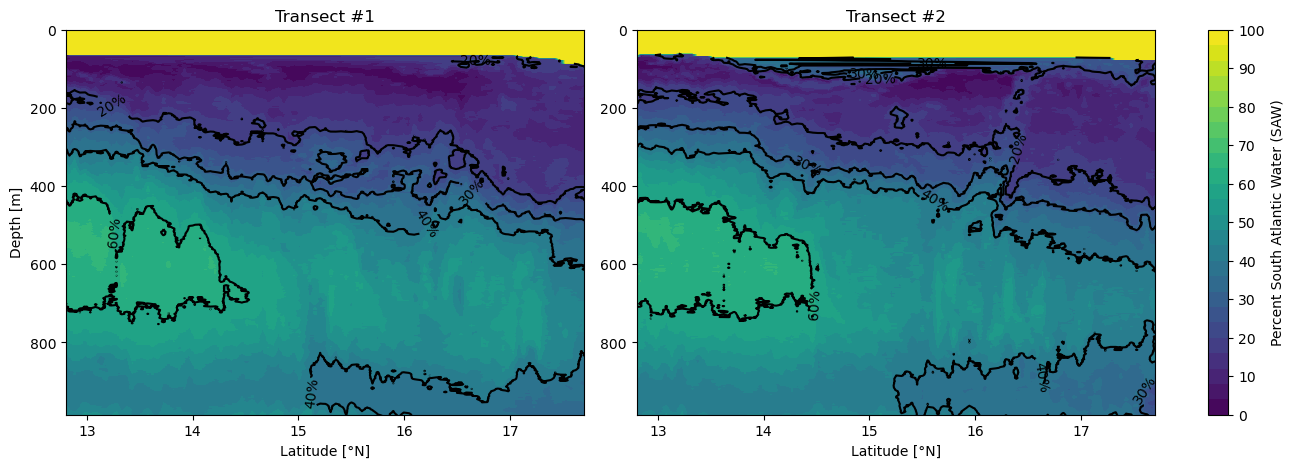

In [19]:
# Preprocess both transects
t1_vals = np.nan_to_num(interp_transect1.saw_frac * 100, nan=100)
t1_masked = np.ma.masked_where(np.isnan(interp_transect1.saw_frac), t1_vals)

t2_vals = np.nan_to_num(interp_transect2.saw_frac * 100, nan=100)
t2_masked = np.ma.masked_where(np.isnan(interp_transect2.saw_frac), t2_vals)

# Create figure with GridSpec layout
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.04], wspace=0.15)

# Plot Transect 1
ax1 = fig.add_subplot(gs[0])
cf1 = ax1.contourf(
    interp_transect1.latitude, interp_transect1.depth, t1_vals,
    levels=np.arange(0, 101, 4), vmin=0, vmax=100, cmap='viridis'
)
cs1 = ax1.contour(
    interp_transect1.latitude, interp_transect1.depth, t1_masked,
    levels=[20, 30,40, 60], colors='black', linewidths=1.5
)
ax1.clabel(cs1, fmt='%d%%', colors='black')
ax1.set_title('Transect #1')
ax1.set_xlabel('Latitude [°N]')
ax1.set_ylabel('Depth [m]')
ax1.set_ylim(985, 0)
ax1.set_xlim(12.8, 17.7)

# Plot Transect 2
ax2 = fig.add_subplot(gs[1], sharey=ax1)
cf2 = ax2.contourf(
    interp_transect2.latitude, interp_transect2.depth, t2_vals,
    levels=np.arange(0, 101, 4), vmin=0, vmax=100, cmap='viridis'
)
cs2 = ax2.contour(
    interp_transect2.latitude, interp_transect2.depth, t2_masked,
    levels=[20,30,40, 60], colors='black', linewidths=1.5
)
ax2.clabel(cs2, fmt='%d%%', colors='black')
ax2.set_title('Transect #2')
ax2.set_xlabel('Latitude [°N]')
ax2.set_xlim(12.8, 17.7)

# Colorbar on the right
cax = fig.add_subplot(gs[2])
cbar = fig.colorbar(cf2, cax=cax, ticks=np.arange(0, 101, 10))
cbar.set_label('Percent South Atlantic Water (SAW)')

plt.tight_layout()
plt.show()


## Put results from water mass analysis on the adcp grid

In [20]:
subset_transect1_gridded_glider_e_mean = subset_transect1_gridded_glider_e.groupby("time").mean()
subset_transect2_gridded_glider_e_mean = subset_transect2_gridded_glider_e.groupby("time").mean()

subset_transect1_glider_interp = subset_transect1_gridded_glider_e_mean.interp(depth=transect1_ad2cp.depth, time=transect1_ad2cp.time, method="linear")
subset_transect2_glider_interp = subset_transect2_gridded_glider_e_mean.interp(depth=transect2_ad2cp.depth, time=transect2_ad2cp.time, method="linear")

transect1_ad2cp["saw_frac"] = subset_transect1_glider_interp["saw_frac"].transpose()
transect1_ad2cp["naw_frac"] = subset_transect1_glider_interp["naw_frac"].transpose()
transect1_ad2cp["conservative_temperature"] = subset_transect1_glider_interp["conservative_temperature"].transpose()
transect1_ad2cp["absolute_salinity"] = subset_transect1_glider_interp["absolute_salinity"].transpose()
transect1_ad2cp["sigma"] = subset_transect1_glider_interp["sigma"].transpose()
transect1_ad2cp["oxygen_concentration_shifted_mgL"] = subset_transect1_glider_interp["oxygen_concentration_shifted_mgL"].transpose()

transect2_ad2cp["saw_frac"] = subset_transect2_glider_interp["saw_frac"].transpose()
transect2_ad2cp["naw_frac"] = subset_transect2_glider_interp["naw_frac"].transpose()
transect2_ad2cp["conservative_temperature"] = subset_transect2_glider_interp["conservative_temperature"].transpose()
transect2_ad2cp["absolute_salinity"] = subset_transect2_glider_interp["absolute_salinity"].transpose()
transect2_ad2cp["sigma"] = subset_transect2_glider_interp["sigma"].transpose()
transect2_ad2cp["oxygen_concentration_shifted_mgL"] = subset_transect2_glider_interp["oxygen_concentration_shifted_mgL"].transpose()
transect2_ad2cp

<xarray.Dataset> Size: 784kB
Dimensions:                           (depth: 100, time: 121)
Coordinates:
  * time                              (time) datetime64[ns] 968B 2024-05-18T1...
  * depth                             (depth) float64 800B 5.0 15.0 ... 995.0
Data variables: (12/16)
    u_grid                            (depth, time) float64 97kB ...
    v_grid                            (depth, time) float64 97kB ...
    latitude                          (time) float64 968B ...
    longitude                         (time) float64 968B ...
    start_lat                         (time) float64 968B ...
    start_lon                         (time) float64 968B ...
    ...                                ...
    saw_frac                          (depth, time) float64 97kB nan nan ... nan
    naw_frac                          (depth, time) float64 97kB nan nan ... nan
    conservative_temperature          (depth, time) float64 97kB nan nan ... nan
    absolute_salinity                 (depth, time) float64 97kB nan nan ... nan
    sigma                             (depth, time) float64 97kB nan nan ... nan
    oxygen_concentration_shifted_mgL  (depth, time) float64 97kB nan nan ... nan
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

## Calculate NAW and SAW transport

In [34]:

transect1_ad2cp = calc_segment_transport(transect1_ad2cp)
transect1_ad2cp = calc_segment_water_mass_transport(transect1_ad2cp)

total_transect_1_transport = np.nansum(transect1_ad2cp.segment_transport)/(10**6)
transect1_naw_transport = np.nansum(transect1_ad2cp.segment_naw_transport)/(10**6)
transect1_saw_transport = np.nansum(transect1_ad2cp.segment_saw_transport)/(10**6)
transect_1_surface_water_transport = total_transect_1_transport-transect1_naw_transport-transect1_saw_transport

print(f'Transect #1 Total Transport {np.round(total_transect_1_transport,3)} Sv')
print(f'Transect #1 NAW Transport {np.round(transect1_naw_transport,3)} Sv')
print(f'Transect #1 SAW Transport {np.round(transect1_saw_transport,3)} Sv')
print(f'Transect #1 Surface Water Transport {np.round(transect_1_surface_water_transport,3)} Sv')
print(f'Transect #1 SAW Transport with Surface Waters {np.round((transect1_saw_transport+transect_1_surface_water_transport),3)} Sv')
print()
print(f'Transect #1 Ratio of NAW/Total Transport {np.round(transect1_naw_transport/total_transect_1_transport,3)}')
print(f'Transect #1 Ratio of SAW/Total Transport {np.round((transect1_saw_transport+transect_1_surface_water_transport)/total_transect_1_transport,3)}')

Transect #1 Total Transport -17.639 Sv
Transect #1 NAW Transport -9.286 Sv
Transect #1 SAW Transport -5.648 Sv
Transect #1 Surface Water Transport -2.706 Sv
Transect #1 SAW Transport with Surface Waters -8.354 Sv

Transect #1 Ratio of NAW/Total Transport 0.526
Transect #1 Ratio of SAW/Total Transport 0.474


In [35]:
transect2_ad2cp = calc_segment_transport(transect2_ad2cp)
transect2_ad2cp = calc_segment_water_mass_transport(transect2_ad2cp)

total_transect_2_transport = np.nansum(transect2_ad2cp.segment_transport)/(10**6)
transect2_naw_transport = np.nansum(transect2_ad2cp.segment_naw_transport)/(10**6)
transect2_saw_transport = np.nansum(transect2_ad2cp.segment_saw_transport)/(10**6)
transect_2_surface_water_transport = total_transect_2_transport-transect2_naw_transport-transect2_saw_transport

print(f'Transect #2 Total Transport {np.round(total_transect_2_transport,3)} Sv')
print(f'Transect #2 NAW Transport {np.round(transect2_naw_transport,3)} Sv')
print(f'Transect #2 SAW Transport {np.round(transect2_saw_transport,3)} Sv')
print(f'Transect #2 Surface Water Transport {np.round(transect_2_surface_water_transport,3)} Sv')
print(f'Transect #2 SAW Transport with Surface Waters {np.round((transect2_saw_transport+transect_2_surface_water_transport),3)} Sv')
print()
print(f'Transect #2 Ratio of NAW/Total Transport {np.round(transect2_naw_transport/total_transect_2_transport,3)}')
print(f'Transect #2 Ratio of SAW/Total Transport {np.round((transect2_saw_transport+transect_2_surface_water_transport)/total_transect_2_transport,3)}')

Transect #2 Total Transport -9.223 Sv
Transect #2 NAW Transport -4.628 Sv
Transect #2 SAW Transport -5.835 Sv
Transect #2 Surface Water Transport 1.24 Sv
Transect #2 SAW Transport with Surface Waters -4.595 Sv

Transect #2 Ratio of NAW/Total Transport 0.502
Transect #2 Ratio of SAW/Total Transport 0.498


In [38]:
transect_1_water_mass_transport = calc_segment_water_mass_transport_classes(transect1_ad2cp)
transect_1_water_mass_transport

,SA,NA,SA2tot
IW,-3.442300,-3.086311,52.726382
lCW,-1.610826,-2.203015,42.236327
uCW,-0.539888,-2.065144,20.724822
SMW,-0.202673,-2.203212,8.424048
SW,-2.705980,NaN,NaN


In [39]:
transect_2_water_mass_transport = calc_segment_water_mass_transport_classes(transect2_ad2cp)
transect_2_water_mass_transport

,SA,NA,SA2tot
IW,-4.249069,-3.588431,54.214597
lCW,-1.457685,-1.581493,47.963124
uCW,-0.094680,-0.095775,49.712327
SMW,0.119104,0.808798,12.835808
SW,1.240135,NaN,NaN


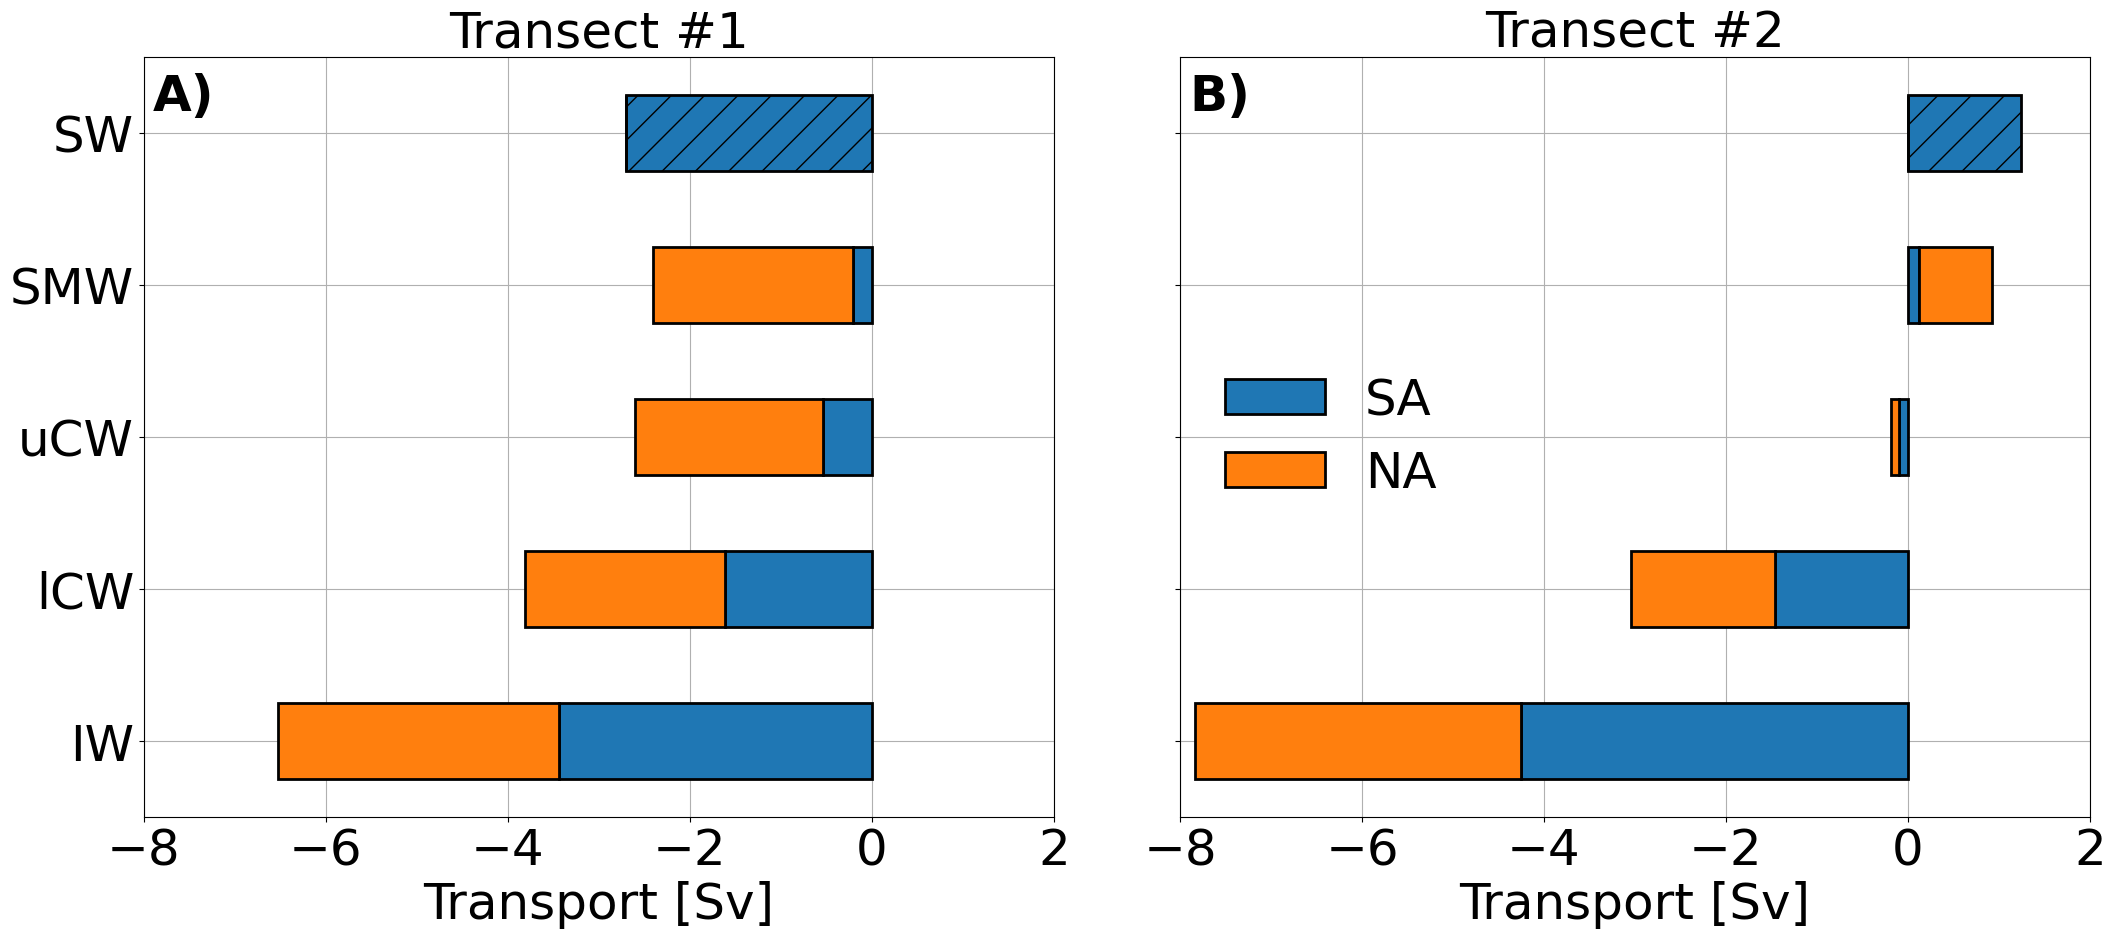

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

plt.tight_layout(pad=0.4, w_pad=6, h_pad=4.5)

font_size = 36

transect_1_water_mass_transport.plot.barh(stacked=True,ax=axs[0],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[0].set_title('Transect #1',fontsize=font_size)
axs[0].set_xlim(-8,2)
#axs[0].set_xticks([-6,-5,-4,-3,-2,-1,0])
axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].get_legend().remove()
axs[0].set_xlabel('Transport [Sv]',fontsize=font_size)
axs[0].text(0.01,0.93,'A)', transform=axs[0].transAxes, size=font_size, weight='bold')
axs[0].set_axisbelow(True)  # grid goes behind plotted elements
axs[0].grid()

transect_2_water_mass_transport.plot.barh(stacked=True,ax=axs[1],color=['tab:blue','tab:orange'], edgecolor='black', linewidth=2)
axs[1].set_title('Transect #2',fontsize=font_size)
axs[1].set_xlim(-8,2)
#axs[1].set_xticks([-6,-5,-4,-3,-2,-1,0])
axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].legend(fontsize=font_size,markerscale=6,frameon=False,loc='center left')
axs[1].set_xlabel('Transport [Sv]',fontsize=font_size)
axs[1].set_yticklabels([])  # Removes y-axis tick labels
axs[1].text(0.01,0.93,'B)', transform=axs[1].transAxes, size=font_size, weight='bold')
axs[1].set_axisbelow(True)  # grid goes behind plotted elements
axs[1].grid()

hatches = ['','','','','/','','','','','']

for x in np.arange(0,len(axs)):    
    bars = axs[x].patches
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

plt.savefig('../figures/RU29_2024_ABC2DR_NAW_SAW_Transport_by_Water_Mass.png',bbox_inches='tight',dpi=300,facecolor='white')

